# MLP Model for Image Classification

This notebook implements a Multilayer Perceptron (MLP) to classify images into 10 categories:
- Adjust Radio
- Drink
- Drive Safe
- Hair & Makeup
- Reach Behind
- Talk Left
- Talk Passenger
- Talk Right
- Text Left
- Text Right


## Import Dependencies

In [ ]:
# Ensure all necessary dependencies are installed before importing
import sys
import subprocess

pkgs = [
    "pandas",
    "numpy",
    "Pillow",
    "torch",
    "torchvision",
    "matplotlib",
    "seaborn",
    "scikit-learn"
]

# Install missing packages silently
subprocess.run([sys.executable, "-m", "pip", "install", *pkgs],
               stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

# Imports
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Data Preparation

In [ ]:
if 'google.colab' in sys.modules:  # using Google Colab
    from google.colab import drive
    drive.mount('/content/drive')
    data_zip_path = "/content/data.zip"
    data_extract_dir = "/content/"
    data_dir = "/content/data"
    train_csv_path = os.path.join(data_dir, "train_data.csv")
    test_csv_path  = os.path.join(data_dir, "test_data.csv")
else:
    data_zip_path = "../data.zip"
    data_extract_dir = "../"
    data_dir = "../data"
    train_csv_path = os.path.join(data_dir, "train_data.csv")
    test_csv_path  = os.path.join(data_dir, "test_data.csv")

def ensure_data_folder_flat(extract_dir, expected_dir_name="data"):
    expected_data_dir = os.path.join(extract_dir, expected_dir_name)
    if os.path.isdir(expected_data_dir):
        # Data is already at the top level
        return

    # Look for a nested 'data' folder one level deep
    for item in os.listdir(extract_dir):
        item_path = os.path.join(extract_dir, item)
        if (
            os.path.isdir(item_path)
            and item != expected_dir_name
        ):
            nested_data = os.path.join(item_path, expected_dir_name)
            if os.path.isdir(nested_data):
                shutil.move(nested_data, expected_data_dir)
                return

if os.path.exists(data_zip_path):
    with zipfile.ZipFile(data_zip_path, 'r') as zip_ref:
        zip_ref.extractall(data_extract_dir)
    ensure_data_folder_flat(data_extract_dir, expected_dir_name="data")

train_dataset = pd.read_csv(train_csv_path)
test_dataset  = pd.read_csv(test_csv_path)

In [50]:
labels = {
    0: "Drive Safe",
    1: "Text Left",
    2: "Talk Left",
    3: "Text Right",
    4: "Talk Right",
    5: "Adjust Radio",
    6: "Drink",
    7: "Hair & Makeup",
    8: "Reach Behind",
    9: "Talk Passenger"
}

label_to_idx = {v: k for k, v in labels.items()}
num_classes = len(labels)

In [51]:
class DistractedDataset(Dataset):
    def __init__(self, csv_path, base_dir="../data", transform=None):
        self.df = pd.read_csv(csv_path)
        self.base_dir = base_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_dir, row["Image"])  
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img) 

        label_str = row["Label"]
        label = label_to_idx[label_str]

        return img, label
img_size = 64

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),    
    
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

In [52]:
full_train_dataset = DistractedDataset(train_csv_path, transform=transform)

train_size = int(0.9 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    full_train_dataset,
    [train_size, val_size]
)

test_dataset = DistractedDataset(test_csv_path, transform=transform)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False)
class MLP(nn.Module):
    def __init__(self, img_size=64, num_classes=10):
        super().__init__()
        input_dim = 3 * img_size * img_size  

        self.net = nn.Sequential(
            nn.Flatten(),                     
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)       
        )

    def forward(self, x):
        return self.net(x)


In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = MLP(img_size=img_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0

    for imgs, labels in loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)              # [B, num_classes]
        loss = criterion(outputs, labels)  # CE Loss

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            outputs = model(imgs)
            loss = criterion(outputs, labels)

            total_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / total
    acc = correct / total
    return avg_loss, acc


Using device: cpu


In [ ]:
EPOCHS = 50    # Adjust as desired

best_val_acc = 0.0
best_model_state = None

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)

    print(f"Epoch {epoch:02d}: "
          f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f}, "
          f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        # Deep copy the best model weights
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        print("  -> New best model!")

# Restore best model (move to device after loading state dict)
best_model = MLP(img_size=img_size, num_classes=num_classes).to(device)
if best_model_state is not None:
    best_model.load_state_dict(best_model_state)
    best_model = best_model.to(device)

KeyboardInterrupt: 

In [ ]:
# Generate predictions for all test images and save to CSV
best_model.eval()
all_predictions = []
all_true_labels = []
all_image_paths = []

# Get image paths and true labels in the same order as DataLoader processes them
test_df = pd.read_csv(test_csv_path)
for idx in range(len(test_dataset)):
    row = test_df.iloc[idx]
    all_image_paths.append(row["Image"])

# Get predictions from test loader (order matches dataset order since shuffle=False)
with torch.no_grad():
    for imgs, true_labels_batch in test_loader:
        imgs = imgs.to(device)
        outputs = best_model(imgs)
        _, preds = outputs.max(1)
        
        # Move predictions back to CPU
        preds = preds.cpu().numpy()
        true_labels_batch = true_labels_batch.cpu().numpy()
        
        all_predictions.extend(preds)
        all_true_labels.extend(true_labels_batch)

# Create DataFrame with predictions
results = []
for i in range(len(all_image_paths)):
    true_label_str = labels[all_true_labels[i]]
    predicted_label_str = labels[all_predictions[i]]
    
    results.append({
        "image": all_image_paths[i],
        "label": true_label_str,
        "predicted_label": predicted_label_str
    })

results_df = pd.DataFrame(results)

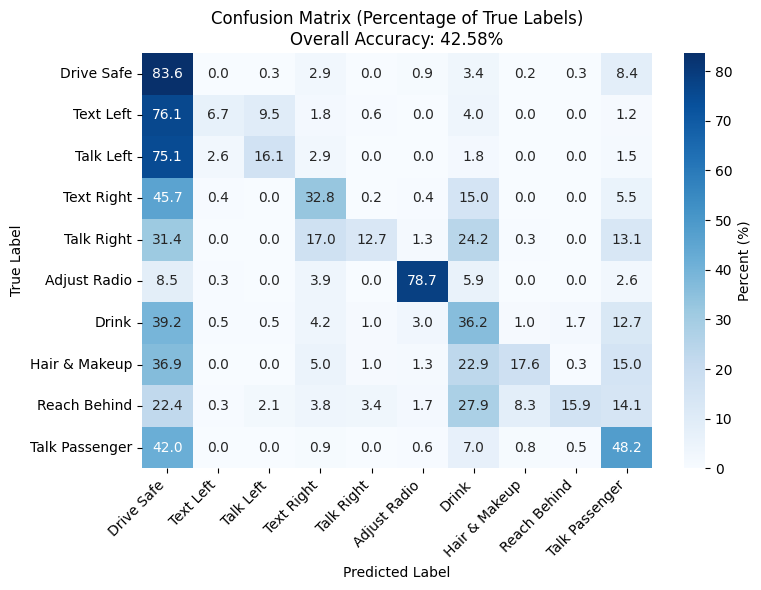

In [ ]:
# If labels is a dictionary mapping index to name, get list of names in order:
if isinstance(labels, dict):
    label_names = [labels[i] for i in range(len(labels))]
else:
    label_names = labels

# Get confusion matrix (normalize by true label, i.e., rows)
cm = confusion_matrix(all_true_labels, all_predictions, normalize='true')

# Calculate overall accuracy
accuracy = (sum([pred == true for pred, true in zip(all_predictions, all_true_labels)]) / len(all_true_labels)) * 100

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cm * 100,
    annot=True,
    fmt=".1f",
    cmap="Blues",
    xticklabels=label_names,
    yticklabels=label_names,
    ax=ax,
    cbar_kws={'label': 'Percent (%)'}
)
ax.set_xlabel("Predicted Label")
ax.set_ylabel("True Label")
ax.set_title(f"Confusion Matrix (Percentage of True Labels)\nOverall Accuracy: {accuracy:.2f}%")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

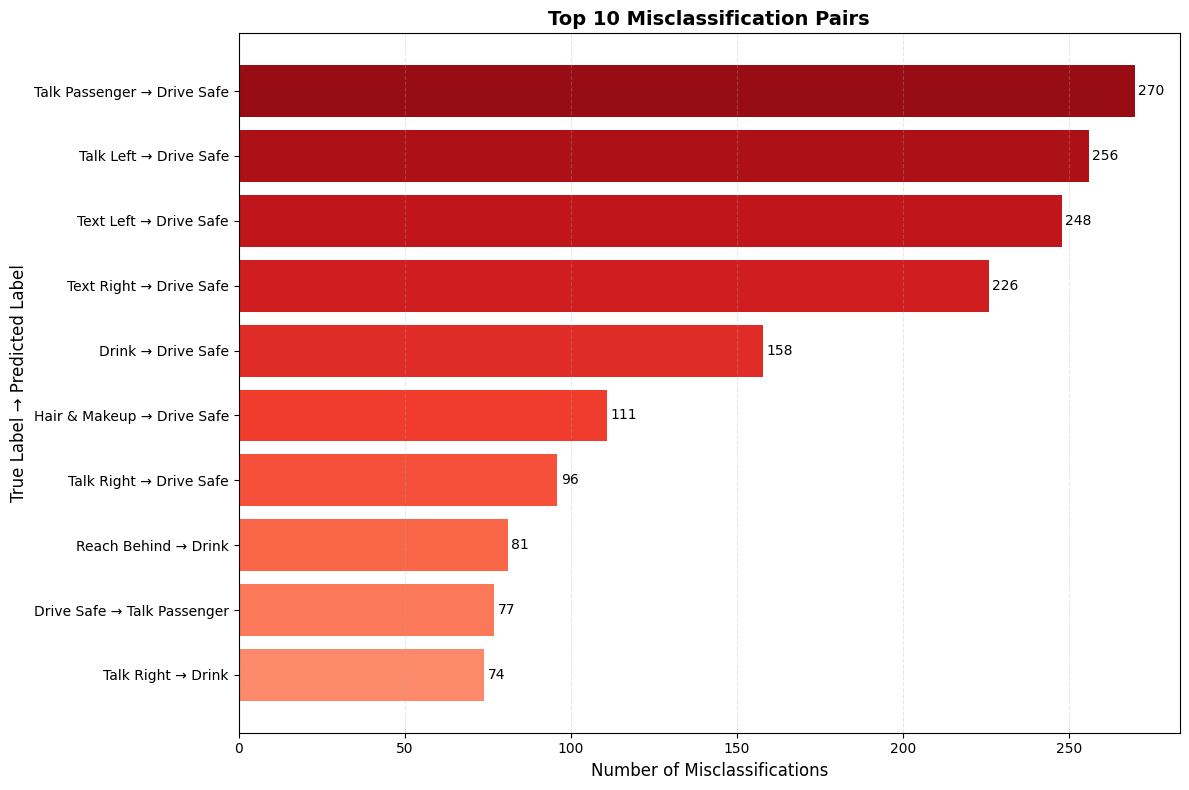

Total misclassifications: 2487
Total test samples: 4331
Accuracy: 42.58%


In [ ]:
# Filter for misclassifications only
misclassifications = results_df[results_df['label'] != results_df['predicted_label']].copy()

# Create misclassification pairs (True -> Predicted)
misclassifications['pair'] = misclassifications['label'] + ' → ' + misclassifications['predicted_label']

# Count frequency of each misclassification pair
pair_counts = misclassifications['pair'].value_counts()

# Get top N misclassification pairs (default: top 10)
top_n = 10
top_pairs = pair_counts.head(top_n)

# Create bar chart
plt.figure(figsize=(12, 8))
colors = plt.cm.Reds(np.linspace(0.9, 0.4, len(top_pairs)))
bars = plt.barh(range(len(top_pairs)), top_pairs.values, color=colors)

plt.yticks(range(len(top_pairs)), top_pairs.index)
plt.xlabel('Number of Misclassifications', fontsize=12)
plt.ylabel('True Label → Predicted Label', fontsize=12)
plt.title(f'Top {top_n} Misclassification Pairs', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Show highest at top

# Add value labels on bars
for i, (idx, val) in enumerate(top_pairs.items()):
    plt.text(val + 1, i, f'{int(val)}', va='center', fontsize=10)

plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Total misclassifications: {len(misclassifications)}")
print(f"Total test samples: {len(results_df)}")
print(f"Accuracy: {(len(results_df) - len(misclassifications)) / len(results_df) * 100:.2f}%")